In [599]:
# For reading our data set
import pandas
# For lots of great things.
import numpy as np
# To make our plots.
import matplotlib.pyplot as plt
%matplotlib inline
# Because sympy and LaTeX make
# everything look wonderful!
from sympy import *
init_printing(use_latex=True)
from IPython.display import display
# We will use this to check our implementation...
from sklearn.decomposition import PCA
# For building our net
import keras
# Need this for LabelEncoder
from sklearn import preprocessing

## Read in data

In [600]:
student_data = np.array(pandas.read_table("./student-por.csv",
delimiter=";", header=0))

student_data

array([['GP', 'F', 18, ..., 0, 11, 11],
       ['GP', 'F', 17, ..., 9, 11, 11],
       ['GP', 'F', 15, ..., 12, 13, 12],
       ...,
       ['MS', 'F', 18, ..., 11, 12, 9],
       ['MS', 'M', 17, ..., 10, 10, 10],
       ['MS', 'M', 18, ..., 10, 11, 11]], dtype=object)

In [601]:
len(student_data)

OSError: [Errno 12] Cannot allocate memory

649

# Data Cleanup

## Shuffle data

In [604]:
np.random.shuffle(student_data)

student_data

array([['MS', 'F', 18, ..., 12, 13, 14],
       ['GP', 'M', 15, ..., 18, 17, 18],
       ['GP', 'M', 18, ..., 10, 9, 10],
       ...,
       ['GP', 'F', 18, ..., 14, 12, 13],
       ['MS', 'F', 16, ..., 9, 10, 10],
       ['GP', 'F', 18, ..., 10, 9, 8]], dtype=object)

## Numerically classify scores

In [605]:
scores = student_data[:,32]

In [606]:
for i in range(len(scores)):
    if(scores[i] > 18):
        scores[i] = 4
    elif(scores[i] > 16):
        scores[i] = 3
    elif(scores[i] > 14):
        scores[i] = 2
    elif(scores[i] > 12):
        scores[i] = 1
    else:
        scores[i] = 0

In [607]:
for i in range(len(scores)):
    student_data[i,32] = scores[i]
    
student_data

array([['MS', 'F', 18, ..., 12, 13, 1],
       ['GP', 'M', 15, ..., 18, 17, 3],
       ['GP', 'M', 18, ..., 10, 9, 0],
       ...,
       ['GP', 'F', 18, ..., 14, 12, 1],
       ['MS', 'F', 16, ..., 9, 10, 0],
       ['GP', 'F', 18, ..., 10, 9, 0]], dtype=object)

## Encoding non-numeric data to integers

In [608]:
# one student sample
student_data[0,:]

array(['MS', 'F', 18, 'U', 'LE3', 'A', 1, 2, 'at_home', 'other',
       'reputation', 'mother', 2, 2, 0, 'no', 'no', 'no', 'no', 'yes',
       'yes', 'yes', 'no', 4, 4, 3, 1, 2, 4, 0, 12, 13, 1], dtype=object)

In [609]:
le = preprocessing.LabelEncoder()

# columns that hold non-numeric data
indices = np.array([0,1,3,4,5,8,9,10,11,15,16,17,18,19,20,21,22])

# transform the non-numeric data in these columns to integers
for i in range(len(indices)):
    column = indices[i]
    le.fit(student_data[:,column])
    student_data[:,column] = le.transform(student_data[:,column])

In [610]:
student_data[0,:]

array([1, 0, 18, 1, 1, 0, 1, 2, 0, 2, 3, 1, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 4, 4, 3, 1, 2, 4, 0, 12, 13, 1], dtype=object)

## Encoding 0's to -1 for binomial data.

In [611]:
# columns that hold binomial data
indices = np.array([0,1,3,4,5,15,16,17,18,19,20,21,22])

# change 0's to -1's
for i in range(len(indices)):
    j = indices[i]
    feature = student_data[:,j]
    feature = np.where(feature==0, -1, feature)
    student_data[:,j] = feature

In [612]:
student_data[0,:]

array([1, -1, 18, 1, 1, -1, 1, 2, 0, 2, 3, 1, 2, 2, 0, -1, -1, -1, -1, 1,
       1, 1, -1, 4, 4, 3, 1, 2, 4, 0, 12, 13, 1], dtype=object)

## Standardizing the nominal and numerical data.

In [613]:
scaler = preprocessing.StandardScaler()

In [614]:
temp = student_data[:,[2,6,7,8,9,10,11,12,13,14,23,24,25,26,27,28,29,30,31]]
Standardized = scaler.fit_transform(temp)

/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [615]:
print('Mean:', round(Standardized.mean()))
print('Standard deviation:', Standardized.std())

Mean: -0.0
Standard deviation: 1.0


In [616]:
student_data[:,[2,6,7,8,9,10,11,12,13,14,23,24,25,26,27,28,29,30,31]] = Standardized

In [617]:
student_data[0,:]

array([1, -1, 1.0316951635937113, 1, 1, -1, -1.3360393847765342,
       -0.2789830500314615, -1.556452535644832, -0.2607275884816344,
       1.5846512634547596, 0.3326475069742609, 0.57671799145725,
       0.08365294968062233, -0.3743051181921297, -1, -1, -1, -1, 1, 1, 1,
       -1, 0.07260614867809903, 0.7804782639289712, -0.1573803313198222,
       -0.5435553304269218, -0.2185083370694357, 0.3209301762731737,
       -0.7891594563761749, 0.2190637219551519, 0.4911367513733601, 1],
      dtype=object)

## Convert results to one-hot encoding

In [618]:
# final grades
results = student_data[:,32]

# all unique values for final grades (0-4)
possible_results = Matrix(np.unique(student_data[:,32])).T

In [619]:
# one-hot encode final grades which will be used as our output
y = keras.utils.to_categorical(results,len(possible_results))

In [620]:
y[0:5]

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [621]:
# our input, all features except final grades
x = student_data[:,0:32]

# Model Building

In [622]:
def create_network(model):
    # specify input/output size
    input_size = x.shape[1]
    output_size = y.shape[1]

    # creeate the hidden layer
    model.add(keras.layers.Dense(800, input_dim = input_size, activation = 'relu'))

    # additional hidden layer
    model.add(keras.layers.Dense(400,activation='relu'))

    # output layer
    model.add(keras.layers.Dense(output_size,activation='softmax'))

    # compile - why using adamax?
    model.compile(loss='categorical_crossentropy',
                  optimizer='adamax', 
                  metrics=['accuracy'])

In [623]:
model = keras.Sequential()
create_network(model)

# Initial Test of the Network

In [624]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

y_train = y[0:518,:]
y_test = y[519:649,:]

In [625]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [626]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5408766287611797
Test accuracy: 0.7307692307692307


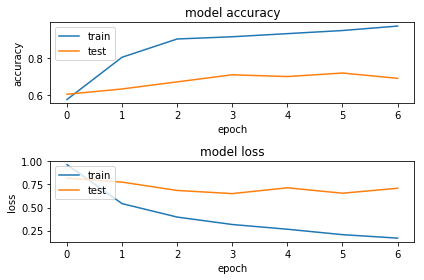

In [627]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without first input
school

In [628]:
x = np.delete(student_data, 0, axis = 1)

In [629]:
x

array([[-1, 1.0316951635937113, 1, ..., 0.2190637219551519,
        0.4911367513733601, 1],
       [1, -1.4329802763043944, 1, ..., 2.4063307303996653,
        1.8650494739652166, 3],
       [1, 1.0316951635937113, -1, ..., -0.510025280859686,
        -0.8827759712184965, 0],
       ...,
       [-1, 1.0316951635937113, 1, ..., 0.9481527247699898,
        0.14765857072539595, 1],
       [-1, -0.6114217963383591, 1, ..., -0.8745697822671049,
        -0.5392977905705323, 0],
       [-1, 1.0316951635937113, 1, ..., -0.510025280859686,
        -0.8827759712184965, 0]], dtype=object)

In [630]:
model = keras.Sequential()
create_network(model)

In [631]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [632]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [633]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18187290570304657
Test accuracy: 0.9076923076923077


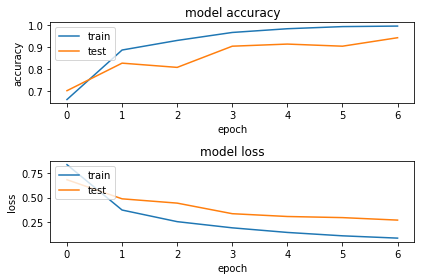

In [634]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without second input
sex

In [635]:
x = np.delete(student_data, 1, axis = 1)

In [636]:
model = keras.Sequential()
create_network(model)

In [637]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [638]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [639]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19289718694478955
Test accuracy: 0.9153846153846154


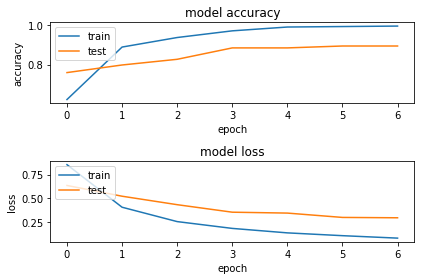

In [640]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without third input
age

In [641]:
x = np.delete(student_data, 2, axis = 1)

In [642]:
model = keras.Sequential()
create_network(model)

In [643]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [644]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [645]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20332395557958918
Test accuracy: 0.9153846153846154


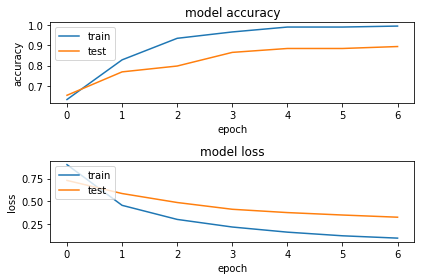

In [646]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without fourth input
address

In [647]:
x = np.delete(student_data, 3, axis = 1)

In [648]:
model = keras.Sequential()
create_network(model)

In [649]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [650]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [651]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1981540064121453
Test accuracy: 0.9307692307692308


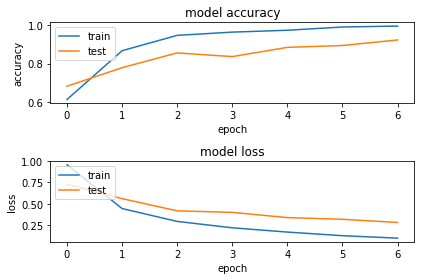

In [652]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without fifth input
famsize

In [653]:
x = np.delete(student_data, 4, axis = 1)

In [654]:
model = keras.Sequential()
create_network(model)

In [655]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [656]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [657]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2218518350667392
Test accuracy: 0.9076923076923077


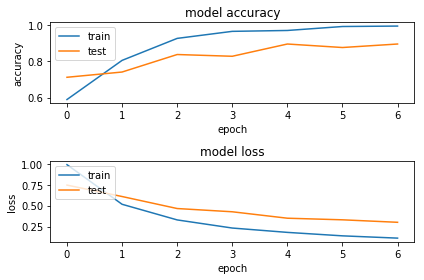

In [658]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without sixth input
parent's cohabitation status

In [659]:
x = np.delete(student_data, 5, axis = 1)

In [660]:
model = keras.Sequential()
create_network(model)

In [661]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [662]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [663]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18846277496061073
Test accuracy: 0.9230769230769231


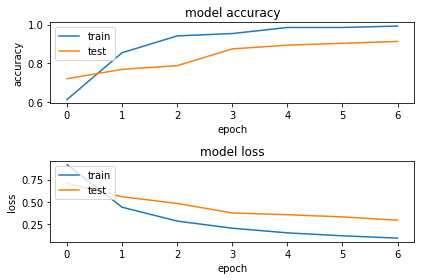

In [664]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without seventh input
mother's education

In [665]:
x = np.delete(student_data, 6, axis = 1)

In [666]:
model = keras.Sequential()
create_network(model)

In [667]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [668]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [669]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18997173705496467
Test accuracy: 0.8923076923076924


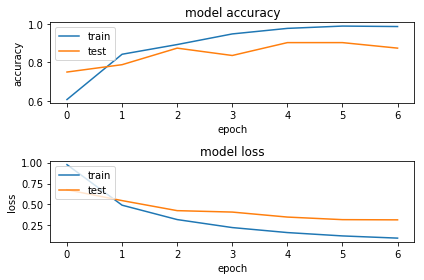

In [670]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without eighth input
father's education

In [671]:
x = np.delete(student_data, 7, axis = 1)

In [672]:
model = keras.Sequential()
create_network(model)

In [673]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [674]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [675]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17215168376703963
Test accuracy: 0.9153846153846154


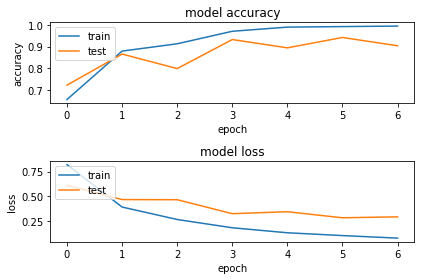

In [676]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without ninth input
mother's job

In [677]:
x = np.delete(student_data, 8, axis = 1)

In [678]:
model = keras.Sequential()
create_network(model)

In [679]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [680]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [681]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20645599722181662
Test accuracy: 0.9076923076923077


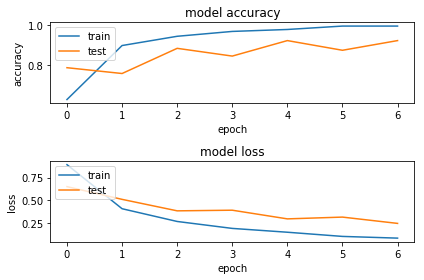

In [682]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without tenth input
father's job

In [683]:
x = np.delete(student_data, 9, axis = 1)

In [684]:
model = keras.Sequential()
create_network(model)

In [685]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [686]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [687]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21962814894683946
Test accuracy: 0.9153846153846154


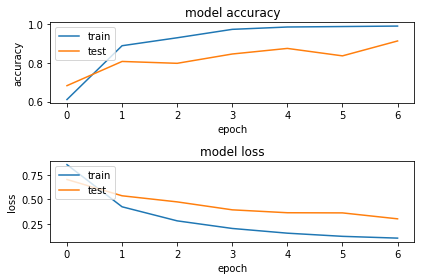

In [688]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without eleventh input
reason to choose school

In [689]:
x = np.delete(student_data, 10, axis = 1)

In [690]:
model = keras.Sequential()
create_network(model)

In [691]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [692]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [693]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15855310761208574
Test accuracy: 0.9538461538461539


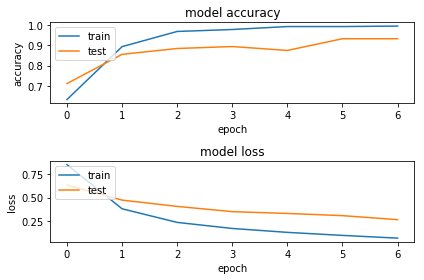

In [694]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without twelvth input
guardian

In [695]:
x = np.delete(student_data, 11, axis = 1)

In [696]:
model = keras.Sequential()
create_network(model)

In [697]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [698]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [699]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19722920819185674
Test accuracy: 0.9307692307692308


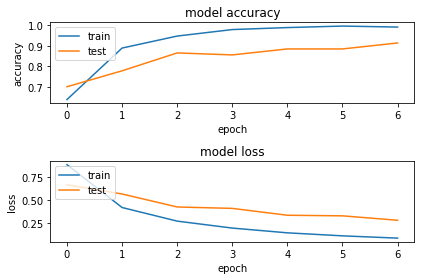

In [700]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without thirteenth input
travel time

In [701]:
x = np.delete(student_data, 12, axis = 1)

In [702]:
model = keras.Sequential()
create_network(model)

In [703]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [704]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [705]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18751086857742988
Test accuracy: 0.9230769230769231


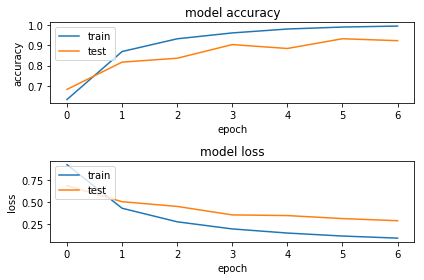

In [706]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without fourteenth input
study time

In [707]:
x = np.delete(student_data, 13, axis = 1)

In [708]:
model = keras.Sequential()
create_network(model)

In [709]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [710]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [711]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20168314047444325
Test accuracy: 0.9230769230769231


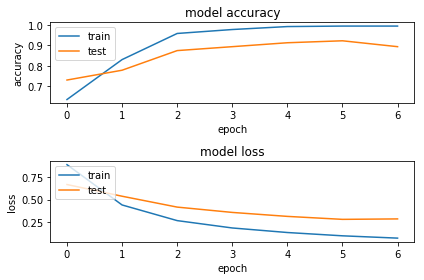

In [712]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without fifteenth input
failures

In [713]:
x = np.delete(student_data, 14, axis = 1)

In [714]:
model = keras.Sequential()
create_network(model)

In [715]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [716]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [717]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.184582373757775
Test accuracy: 0.9230769230769231


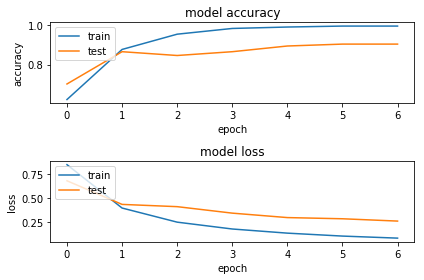

In [718]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without sixteenth input
school support

In [719]:
x = np.delete(student_data, 15, axis = 1)

In [720]:
model = keras.Sequential()
create_network(model)

In [721]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [722]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [723]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2173791083193814
Test accuracy: 0.9


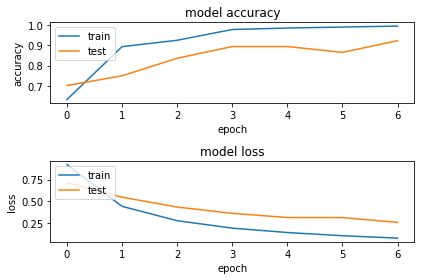

In [724]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without seventeenth input
family support

In [725]:
x = np.delete(student_data, 16, axis = 1)

In [726]:
model = keras.Sequential()
create_network(model)

In [727]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [728]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [729]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21511082550546584
Test accuracy: 0.8923076923076924


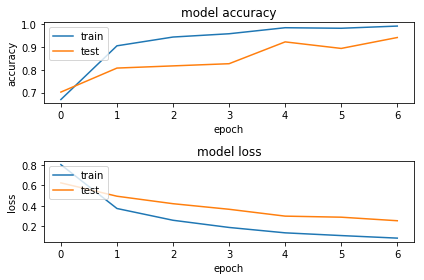

In [730]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without eighteenth input
paid class

In [731]:
x = np.delete(student_data, 17, axis = 1)

In [732]:
model = keras.Sequential()
create_network(model)

In [733]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [734]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [735]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19555481020092536
Test accuracy: 0.9076923076923077


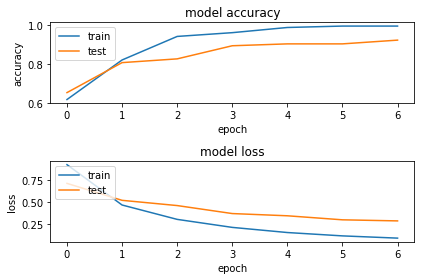

In [736]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without nineteenth input
activities

In [737]:
x = np.delete(student_data, 18, axis = 1)

In [738]:
model = keras.Sequential()
create_network(model)

In [739]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [740]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [741]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2146355193708307
Test accuracy: 0.8923076923076924


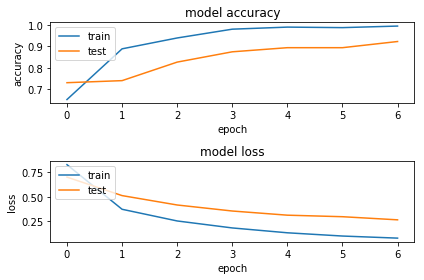

In [742]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without twentieth input
nursery

In [743]:
x = np.delete(student_data, 19, axis = 1)

In [744]:
model = keras.Sequential()
create_network(model)

In [745]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [746]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [747]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18917766649705858
Test accuracy: 0.9307692307692308


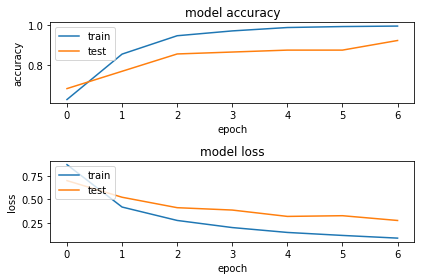

In [748]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without twenty-first input
higher

In [749]:
x = np.delete(student_data, 20, axis = 1)

In [750]:
model = keras.Sequential()
create_network(model)

In [751]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [752]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [753]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22683165278464842
Test accuracy: 0.8846153846153846


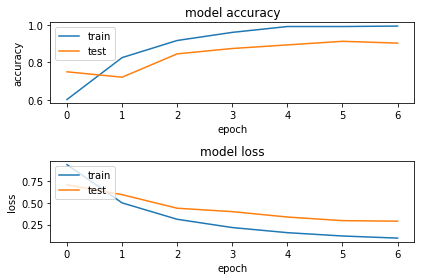

In [754]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without twenty-second input
internet

In [755]:
x = np.delete(student_data, 21, axis = 1)

In [756]:
model = keras.Sequential()
create_network(model)

In [757]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [758]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [759]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20440415952739735
Test accuracy: 0.9076923076923077


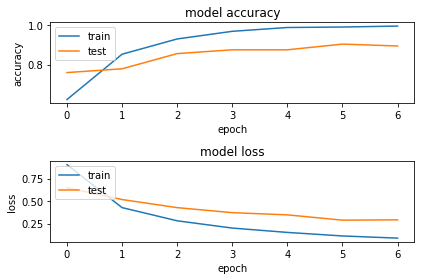

In [760]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without twenty-third input
romantic

In [761]:
x = np.delete(student_data, 22, axis = 1)

In [762]:
model = keras.Sequential()
create_network(model)

In [763]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [764]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [765]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20102303826536697
Test accuracy: 0.9307692307692308


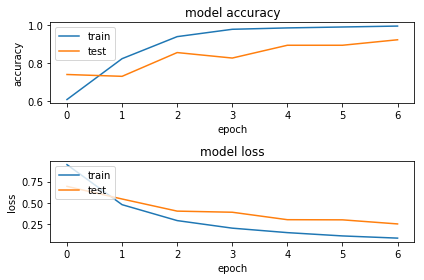

In [766]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without twenty-fourth input

In [767]:
x = np.delete(student_data, 23, axis = 1)

In [768]:
model = keras.Sequential()
create_network(model)

In [769]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [770]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [771]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.204406498089576
Test accuracy: 0.9153846153846154


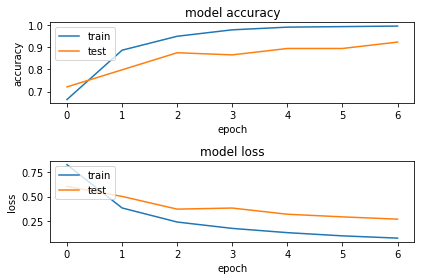

In [772]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without twenty-fifth input
free time

In [773]:
x = np.delete(student_data, 24, axis = 1)

In [774]:
model = keras.Sequential()
create_network(model)

In [775]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [776]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [777]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20945542777458637
Test accuracy: 0.9


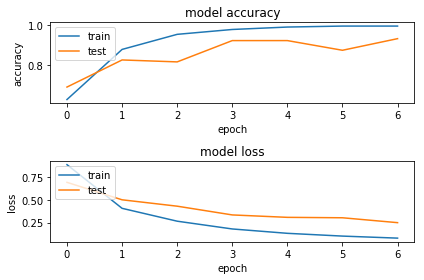

In [778]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without twenty-sixth input
go out

In [779]:
x = np.delete(student_data, 25, axis = 1)

In [780]:
model = keras.Sequential()
create_network(model)

In [781]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [782]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [783]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22894167417320066
Test accuracy: 0.9


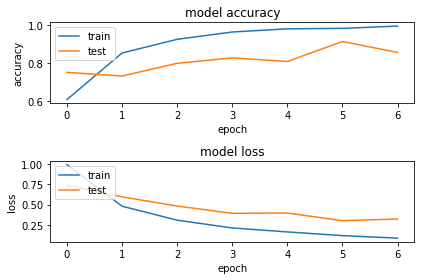

In [784]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without twenty-seventh input
weekend alcohol

In [785]:
x = np.delete(student_data, 26, axis = 1)

In [786]:
model = keras.Sequential()
create_network(model)

In [787]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [788]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [789]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19164644713835935
Test accuracy: 0.9230769230769231


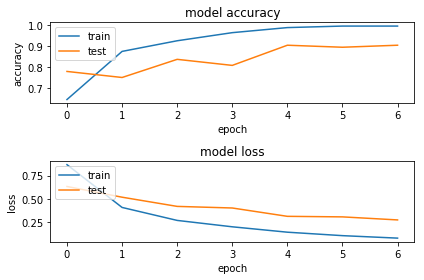

In [790]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without twenty-eighth input
weekday alcohol

In [791]:
x = np.delete(student_data, 27, axis = 1)

In [792]:
model = keras.Sequential()
create_network(model)

In [793]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [794]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [795]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20258377503352956
Test accuracy: 0.8923076923076924


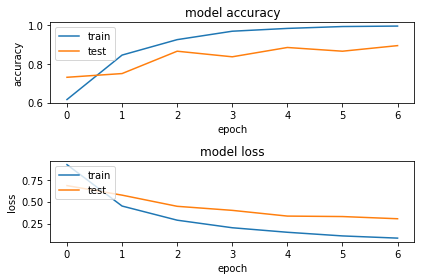

In [796]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without twenty-ninth input
health

In [797]:
x = np.delete(student_data, 28, axis = 1)

In [798]:
model = keras.Sequential()
create_network(model)

In [799]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [800]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [801]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19935927348426327
Test accuracy: 0.8923076923076924


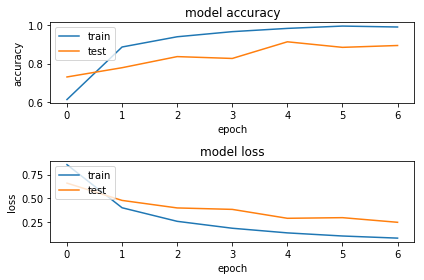

In [802]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without thirtieth input
absences

In [803]:
x = np.delete(student_data, 29, axis = 1)

In [804]:
model = keras.Sequential()
create_network(model)

In [805]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [806]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [807]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1856451749165829
Test accuracy: 0.9384615384615385


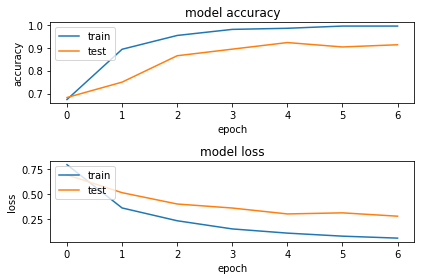

In [808]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without thirty-first input
G1

In [809]:
x = np.delete(student_data, 30, axis = 1)

In [810]:
model = keras.Sequential()
create_network(model)

In [811]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [812]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [813]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16732248865211238
Test accuracy: 0.9230769230769231


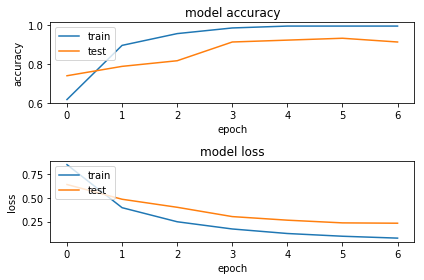

In [814]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without thirty-second input
G2

In [815]:
x = np.delete(student_data, 31, axis = 1)

In [816]:
model = keras.Sequential()
create_network(model)

In [817]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [818]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [819]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23292234227097092
Test accuracy: 0.8692307692307693


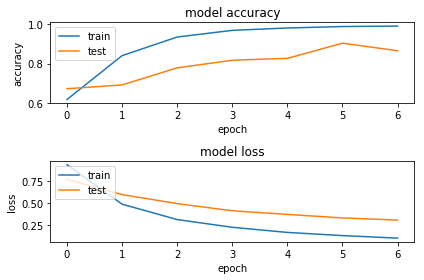

In [820]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without thirty-third input
G3

In [821]:
x = np.delete(student_data, 32, axis = 1)

In [822]:
model = keras.Sequential()
create_network(model)

In [823]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [824]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [825]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5473876160533669
Test accuracy: 0.7461538461538462


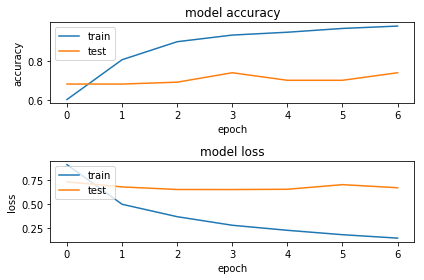

In [826]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# without internet(21), higher(20), father's job(9), mother's job(8), or father's education(7)

In [827]:
x = np.delete(student_data, 21, axis = 1)
x = np.delete(x, 20, axis = 1)
x = np.delete(x, 9, axis = 1)
x = np.delete(x, 8, axis = 1)
x = np.delete(x, 7, axis = 1)

In [828]:
model = keras.Sequential()
create_network(model)

In [829]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

In [830]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [831]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14056774901244073
Test accuracy: 0.9615384615384616


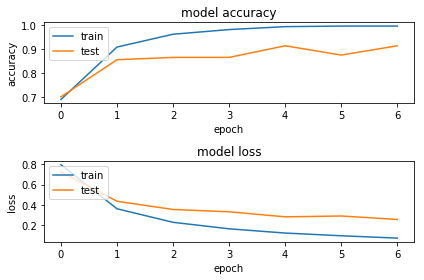

In [832]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()

# Further Analysis

In [873]:
# function for analyzing the percent of students with each grade [F,D,C,B,A]
def analyze(array):
    sums = np.array([0,0,0,0,0])
    for i in range(len(array)):
        if(array[i]==0):
            sums[0] += 1
        elif(array[i]==1):
            sums[1] +=1
        elif(array[i]==2):
            sums[2] +=1
        elif(array[i]==3):
            sums[3] +=1
        else:
            sums[4] += 1
    # total number of students
    total = sums[0] + sums[1] + sums[2] + sums[3] + sums[4]
    # hold percentage of students with grade of [F,D,C,B,A]
    percentages = np.array([sums[0]/total*100, 
                            sums[1]/total*100, 
                            sums[2]/total*100, 
                            sums[3]/total*100, 
                            sums[4]/total*100])
    x = np.array([1,2,3,4,5])
    plt.xticks(np.arange(6), ('', 'F', 'D', 'C', 'B','A'))
    plt.bar(x,percentages)
    plt.xlabel("Grades")
    plt.ylabel("Percentage of Students")
    plt.show()
    print(percentages)

## Family Support

In [874]:
fam_sup = []
no_fam_sup = []
for i in range(student_data.shape[0]):
    sup = student_data[i][16]
    # must compare to specific, mean-centered data
    if(sup==1):
        fam_sup.append(student_data[i][32])
    else:
        no_fam_sup.append(student_data[i][32])

### Family Educational Support

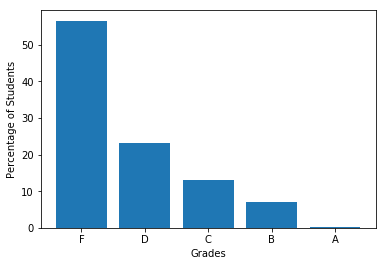

[56.53266332 23.11557789 13.06532663  7.03517588  0.25125628]


In [875]:
analyze(fam_sup)

### No Family Educational Support

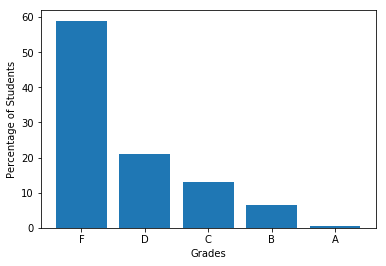

[58.96414343 21.11553785 13.14741036  6.37450199  0.39840637]


In [876]:
analyze(no_fam_sup)

## Reason for choosing school

In [877]:
# each array holds the grades of students who chose to go to their school for that reason
# close to home
reason1 = []
# school reputation
reason2 = []
# course prefrence
reason3 = []
# other
reason4 = []
unique_reasons = np.unique(student_data[:,10])
for i in range(student_data.shape[0]):
    reason = student_data[i][10]
    # must compare to specific, mean-centered data
    if(reason==unique_reasons[0]):
        reason1.append(student_data[i][32])
    elif(reason==unique_reasons[1]):
        reason2.append(student_data[i][32])
    elif(reason==unique_reasons[2]):
        reason3.append(student_data[i][32])
    else:
        reason4.append(student_data[i][32])

### Reason 1: Close to Home

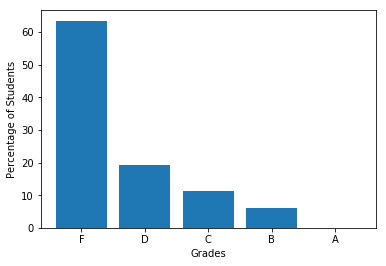

[63.50877193 19.29824561 11.22807018  5.96491228  0.        ]


In [878]:
analyze(reason1)

### Reason 2: School Reputation

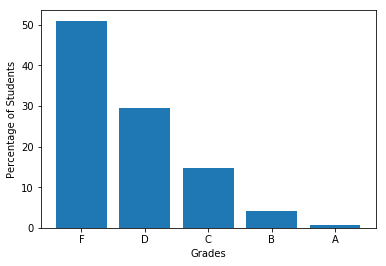

[51.00671141 29.53020134 14.76510067  4.02684564  0.67114094]


In [879]:
analyze(reason2)

### Reason 3: Course Prefrence

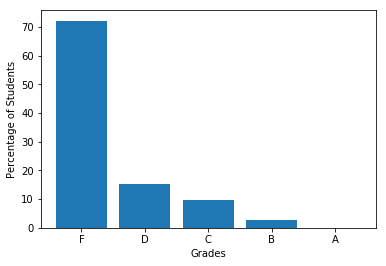

[72.22222222 15.27777778  9.72222222  2.77777778  0.        ]


In [880]:
analyze(reason3)

### Reason 4: Other

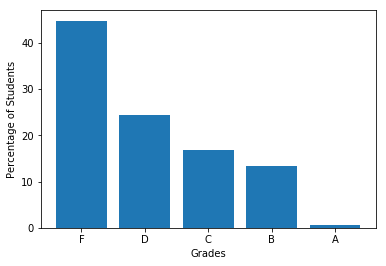

[44.75524476 24.47552448 16.78321678 13.28671329  0.6993007 ]


In [881]:
analyze(reason4)

## Frequency of Going Out With Friends

In [882]:
# each array holds the grades of students who go out with friends for that specified amount of time (1 - very low, 5 - very high)
go_out1 = []
go_out2 = []
go_out3 = []
go_out4 = []
go_out5 = []
unique = np.unique(student_data[:,25])
for i in range(student_data.shape[0]):
    frequency = student_data[i][25]
    # must compare to specific, mean-centered data
    if(frequency==unique[0]):
        go_out1.append(student_data[i][32])
    elif(frequency==unique[1]):
        go_out2.append(student_data[i][32])
    elif(frequency==unique[2]):
        go_out3.append(student_data[i][32])
    elif(frequency==unique[3]):
        go_out4.append(student_data[i][32])
    else:
        go_out5.append(student_data[i][32])

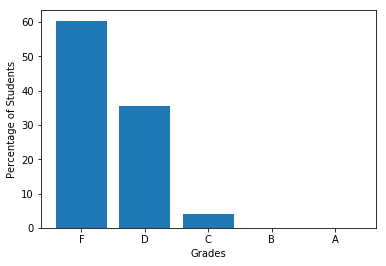

[60.41666667 35.41666667  4.16666667  0.          0.        ]


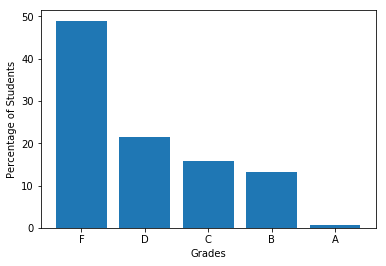

[48.96551724 21.37931034 15.86206897 13.10344828  0.68965517]


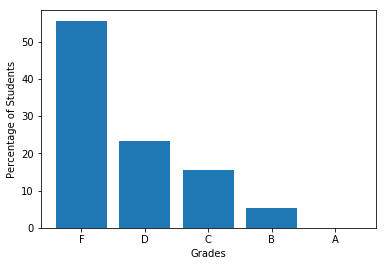

[55.6097561  23.41463415 15.6097561   5.36585366  0.        ]


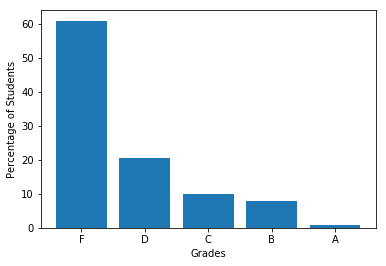

[60.9929078  20.56737589  9.92907801  7.80141844  0.70921986]


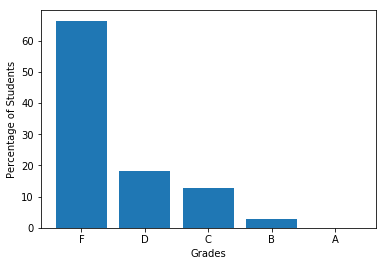

[66.36363636 18.18181818 12.72727273  2.72727273  0.        ]


In [883]:
analyze(go_out1)
analyze(go_out2)
analyze(go_out3)
analyze(go_out4)
analyze(go_out5)

## Free Time after School

In [884]:
# each array holds the grades of students who have the specified amount of free time after school (1 - very low, 5 - very high)
free1 = []
free2 = []
free3 = []
free4 = []
free5 = []
unique = np.unique(student_data[:,24])
for i in range(student_data.shape[0]):
    frequency = student_data[i][24]
    # must compare to specific, mean-centered data
    if(frequency==unique[0]):
        free1.append(student_data[i][32])
    elif(frequency==unique[1]):
        free2.append(student_data[i][32])
    elif(frequency==unique[2]):
        free3.append(student_data[i][32])
    elif(frequency==unique[3]):
        free4.append(student_data[i][32])
    else:
        free5.append(student_data[i][32])

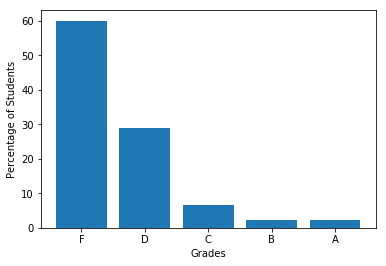

[60.         28.88888889  6.66666667  2.22222222  2.22222222]


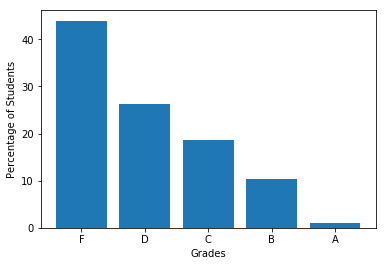

[43.92523364 26.1682243  18.69158879 10.28037383  0.93457944]


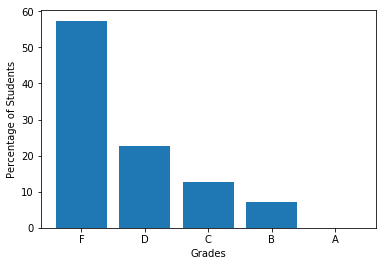

[57.37051793 22.70916335 12.74900398  7.17131474  0.        ]


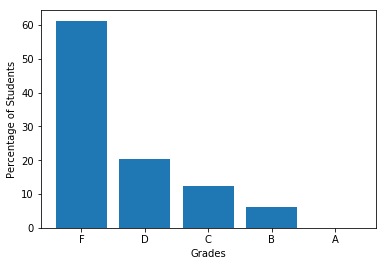

[61.23595506 20.2247191  12.35955056  6.17977528  0.        ]


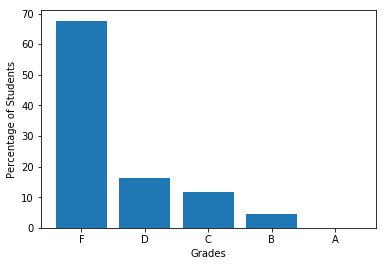

[67.64705882 16.17647059 11.76470588  4.41176471  0.        ]


In [885]:
analyze(free1)
analyze(free2)
analyze(free3)
analyze(free4)
analyze(free5)

## Paid Classes

In [886]:
paid_class = []
no_paid_class = []
for i in range(student_data.shape[0]):
    paid = student_data[i][17]
    # must compare to specific, mean-centered data
    if(paid==1):
        paid_class.append(student_data[i][32])
    else:
        no_paid_class.append(student_data[i][32])

### Extra Paid Classes

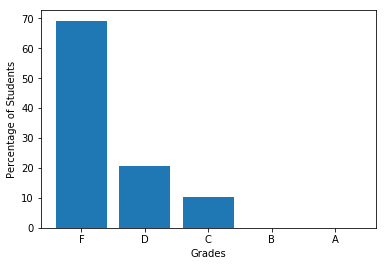

[69.23076923 20.51282051 10.25641026  0.          0.        ]


In [887]:
analyze(paid_class)

### No Extra Paid Classes

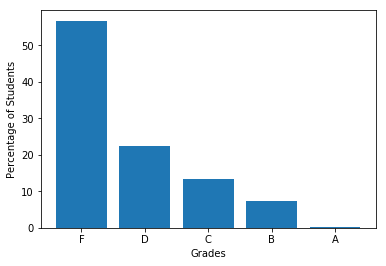

[56.72131148 22.45901639 13.27868852  7.21311475  0.32786885]


In [888]:
analyze(no_paid_class)